This notebooks reads in immune subsets, associates updated annotations from Thomas Walle, and provides hard module assignments for each. 

Note: this notebook has not been double checked yet!

In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import scutils_cnb_clean
from scutils_cnb_clean import *
np.random.seed(23942)

import networkx as nx
import oslom
from argparse import Namespace
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
import scanpy

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
%matplotlib inline

In [4]:
working_dir = '/Users/burdziac/Documents/PDAC/notebooks_final_June2021/'

# Hard-Coded Metadata

In [5]:
color_dict= {"T1 (Basal)":"#DAF7A6",
"T2":"#A1BE6C",
"T3":"#EED04D",
"T3.5":"#D4AA47",
"T4-day1":"#1D89E3",
"T4":"#1D89E3",
"T5":"#F8BADE",
"T6":"#D16BA7",
"T7_PDAC":"#BD14DA",
"T8_LiverMet":"#63009B",
"T8_PDAC_LiverMets":"#63009B",
"T8_PDAC_LungMets":"#63009B"}

In [6]:
stage_dict = {
'DACD408-CD45+':"T3",
 'DACD143-CD45+': 'T5',
 'DACD351-CD45+': 'T3',
 'DACD394-CD45+': 'T3',
 'DACD403-CD45+': 'T2',
 'DACD404-CD45+': 'T4',
 'DACD406-CD45+': 'T3',
 'DACD407-CD45+': 'T4-day1',
 'DACD482-CD45+': 'T5'}

# Load R-L Info

In [7]:
RL = pd.read_csv(working_dir+"misc_files/Ligand_Receptor_Pairs_DAC-curated_TWedit_correctedCNB.csv")[['Ligand','Receptor']]

In [8]:
receptor_fixed = [gene.strip().upper() for gene in RL['Receptor'].dropna().values]
ligand_fixed = [gene.strip().upper() for gene in RL['Ligand'].dropna().values]

# Load Data Original Data and Impute with Magic, Load Modules

## T/NK/ILC

In [9]:
sc = load_sc(working_dir+"saved_analyses/CD45Plus_CrosstalkSubsetBase_TNKILC_v1.pickle")
#use exact modules from paper
cliques_iterative_filtered = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_TNKILC.pickle",'rb'))

In [10]:
#remove 0 sum genes
sc.data_normalized = pd.DataFrame(sc.data_normalized_scran[:,np.where(sc.data_normalized_scran.sum(0)!=0)[0]],
                                  columns = np.array(list(sc.data_normalized_all))[np.where(sc.data_normalized_scran.sum(0)!=0)[0]],
                                  index = sc.data_normalized_all.index)
sc.genes = sc.data_normalized.columns

#impute with MAGIC
magic_operator = magic.MAGIC(t=3,n_pca=50)
sc.data_imputed = magic_operator.fit_transform(np.log2(sc.data_normalized+.1))

Calculating MAGIC...
  Running MAGIC on 3657 cells and 13066 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.01 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.82 seconds.
    Calculating affinities...
    Calculated affinities in 0.79 seconds.
  Calculated graph and diffusion operator in 3.71 seconds.
  Running MAGIC with `solver='exact'` on 13066-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 2.91 seconds.
Calculated MAGIC in 7.44 seconds.


In [11]:
RL_list = list(set(np.concatenate((receptor_fixed,ligand_fixed))))
RL_list = np.intersect1d(RL_list,list(sc.data_normalized))
RLdata_imputed = sc.data_imputed[RL_list]
RLdata_normalized = np.log2(sc.data_normalized[RL_list]+.1)

### Checking Saved Modules Align with Data

In [12]:
RLcorr = np.corrcoef(RLdata_imputed.T)
RLcorr_norm = np.corrcoef(RLdata_normalized.T)

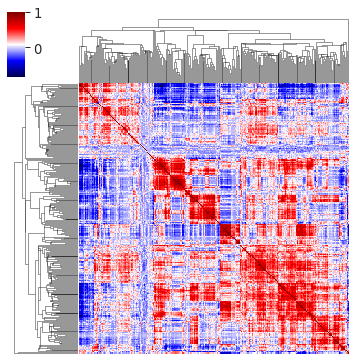

In [13]:
#this clustering better represented module overlap than default
row_clust = scipy.cluster.hierarchy.linkage(RLcorr, method='centroid', metric='euclidean', optimal_ordering=False)

clustmap = sns.clustermap(RLcorr,figsize=(5,5),cmap='seismic',
               yticklabels="",xticklabels="",col_linkage=row_clust,row_linkage=row_clust)

In [14]:
len(cliques_iterative_filtered)

7

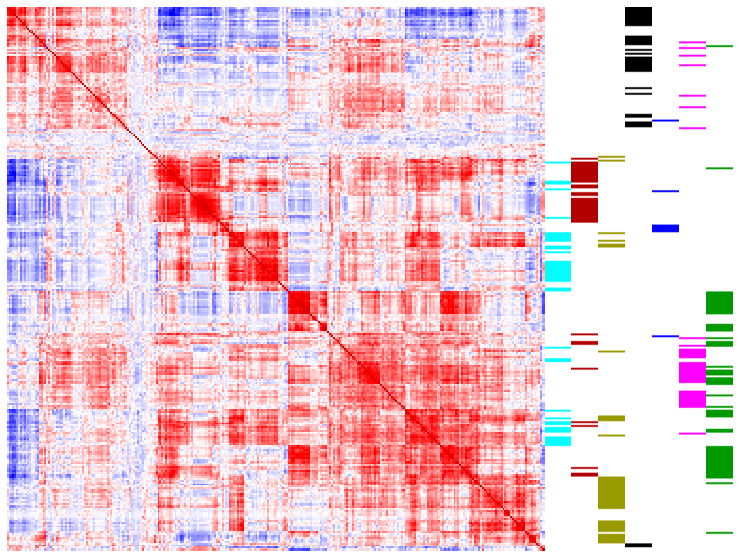

In [15]:
fig,ax=plt.subplots(1,len(cliques_iterative_filtered)+1,figsize=(13,10),
                    gridspec_kw={'width_ratios':[20]+[1]*len(cliques_iterative_filtered)})

rgb_cols_all = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[0,0,0],                         
[0,0,1],
[1,0,1],
[0,.6,0],]) #one row longer than epi

#axis 0: heatmap
RLcorr_reordered = RLcorr[clustmap.dendrogram_row.reordered_ind,:][:,clustmap.dendrogram_row.reordered_ind]
gene_reordered = np.array(RL_list)[clustmap.dendrogram_row.reordered_ind]
sns.heatmap(RLcorr_reordered,cmap='seismic',cbar=False,
               yticklabels="",xticklabels="",vmax=1.5,vmin=-1.5,ax=ax[0])

#axis 1-7: module colors
for j,clique in enumerate(range(len(cliques_iterative_filtered))):
    col_rgb_colors = np.array([rgb_cols_all[j,:] if gene in cliques_iterative_filtered[clique] else np.array([1,1,1]) for gene in gene_reordered])

    #col_rgb_colors = np.asarray([rgb_cols[j,:]])
    ax[j+1].imshow(np.tile(col_rgb_colors[:, None, :], [1, 1000, 1]),aspect="auto")
    ax[j+1].set_axis_off()


plt.subplots_adjust(wspace=0, hspace=.05)
plt.savefig(working_dir+"final_figures/Figure4/ImmuneRLCoexpression_TNKILC.png",bbox_inches='tight')

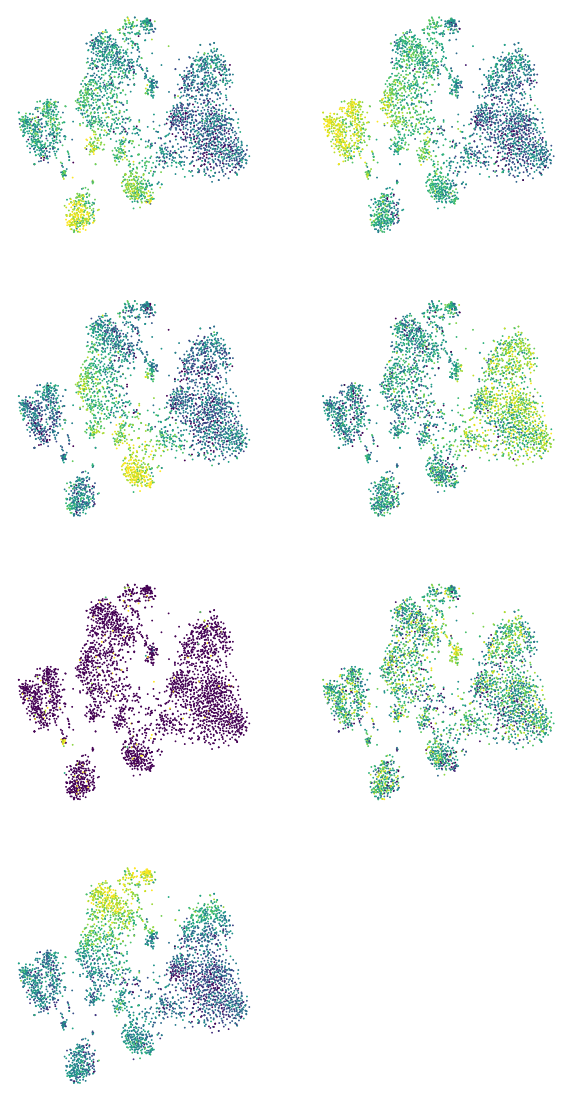

In [16]:
mat = []
fig,axes=plt.subplots(4,2,figsize=(10,20))
i=0
for i,genes in enumerate(cliques_iterative_filtered):
    colors = np.log2(sc.data_normalized[genes].values.mean(1)+.1)
    mat.append(colors)
    order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
    ax = axes.flatten()[i]
    ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],c=colors[order_],s=1,
              cmap='viridis',vmin=np.percentile(colors,2),vmax=np.percentile(colors,98))
    ax.set_axis_off()
    ax.set_title("")
    i+=1
while i < 8:
    axes.flatten()[i].set_axis_off()
    i+=1

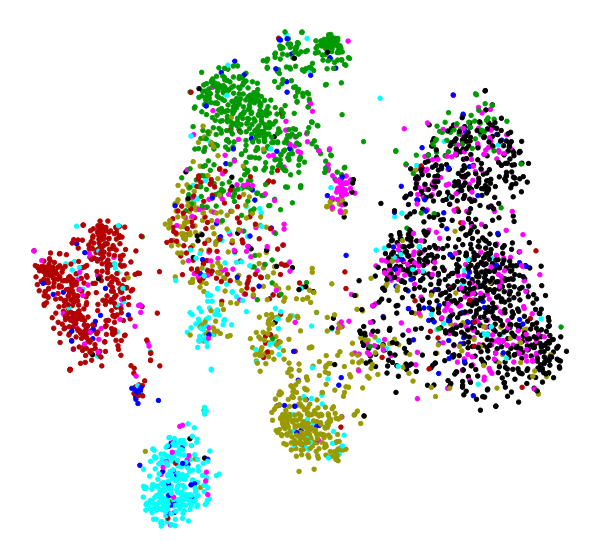

In [17]:
mat = np.vstack(mat)
mat_norm = ((mat.T - mat.mean(1))/mat.std(1)).T

hard_assignments = np.argmax(mat_norm,axis=0)

fig,ax=plt.subplots(1,1,figsize=(10.5,10))
order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
           c=rgb_cols_all[hard_assignments,:][order_,:],s=20)
ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure4/ImmuneCohort_TNKILCModules_Jan-24-22.png",bbox_inches='tight')

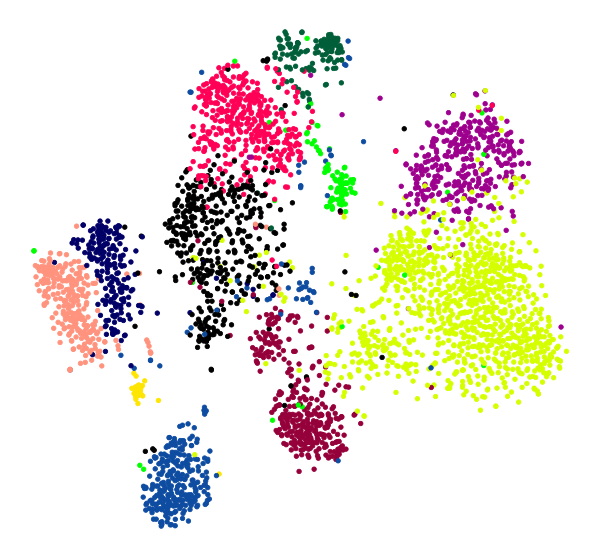

In [18]:
fig,ax=plt.subplots(1,1,figsize=(10.5,10))
encoder = LabelEncoder()
communities = encoder.fit_transform(sc.communities_refined)
cluster_colors = np.array([sc.palette[i] for i in communities])
order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
           c=cluster_colors[order_],s=20)
ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure4/ImmuneCohort_TNKILCClusters_Jan-24-22.png",bbox_inches='tight')

In [19]:
clusters_all = np.array(list(set(sc.communities_refined)))
cluster_sizes = [np.sum(sc.communities_refined==clust) for clust in clusters_all]
cluster_sizes

[266, 29, 321, 204, 337, 107, 1066, 406, 134, 428, 359]

In [20]:
clusters_test = clusters_all[np.where(np.array(cluster_sizes)>10)[0]]

In [21]:
mod_cluster_mat = np.zeros((mat_norm.shape[0],len(clusters_test)))
for module in range(mat_norm.shape[0]):
    mod_ix = np.where(hard_assignments==module)[0]
    
    for i,cluster in enumerate(clusters_test):
        cluster_ix = np.where(sc.communities_refined==cluster)[0]
        mod_cluster_mat[module,i] = len(np.intersect1d(cluster_ix,mod_ix))

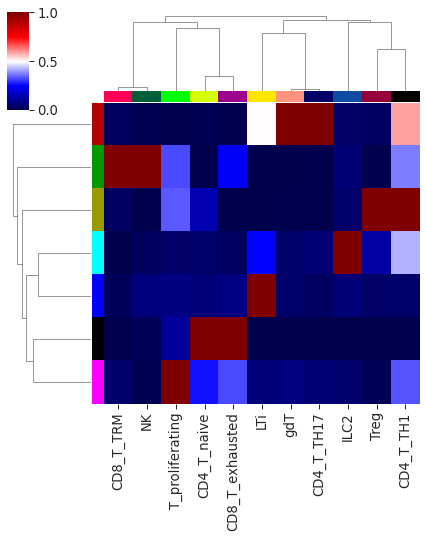

In [22]:
#row_order = [0,1,2,4,5,6,3]
#col_order = [2,3,5,4,0,1]

col_colors = [sc.palette[i] for i in encoder.transform(clusters_test)]

initial = sns.clustermap(mod_cluster_mat,standard_scale=1,cmap='seismic',
              figsize=(6,7.5),#row_cluster=False,col_cluster=False,
               xticklabels=clusters_test,yticklabels="",
               col_colors = col_colors,
               row_colors = rgb_cols_all)

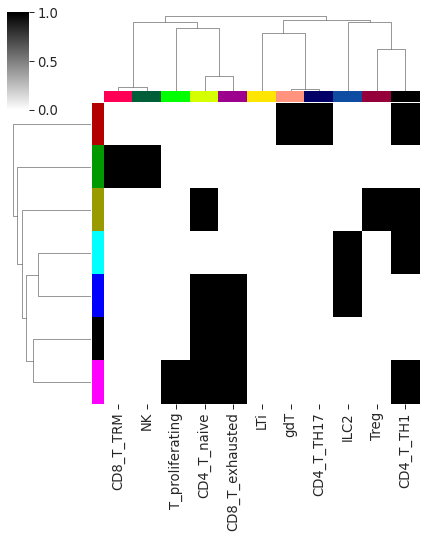

In [23]:
sns.clustermap((mod_cluster_mat.T/mod_cluster_mat.sum(1)).T>.1,cmap='binary',
               row_linkage=initial.dendrogram_row.linkage,
               col_linkage=initial.dendrogram_col.linkage,
               figsize=(6,7.5),#row_cluster=False,col_cluster=False,
               xticklabels=clusters_test,yticklabels="",
               col_colors = col_colors,
               row_colors = rgb_cols_all)

In [24]:
adjusted_rand_score(hard_assignments,sc.communities_refined)

0.34317154826330576

## B

In [25]:
sc = load_sc(working_dir+"saved_analyses/CD45Plus_CrosstalkSubsetBase_B_v1.pickle")
#use exact modules from paper
cliques_iterative_filtered = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_B.pickle",'rb'))

In [26]:
#remove 0 sum genes
sc.data_normalized = pd.DataFrame(sc.data_normalized_scran[:,np.where(sc.data_normalized_scran.sum(0)!=0)[0]],
                                  columns = np.array(list(sc.data_normalized_all))[np.where(sc.data_normalized_scran.sum(0)!=0)[0]],
                                  index = sc.data_normalized_all.index)
sc.genes = sc.data_normalized.columns

#impute with MAGIC
magic_operator = magic.MAGIC(t=3,n_pca=50)
sc.data_imputed = magic_operator.fit_transform(np.log2(sc.data_normalized+.1))

Calculating MAGIC...
  Running MAGIC on 1985 cells and 12637 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.10 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.23 seconds.
  Calculated graph and diffusion operator in 1.67 seconds.
  Running MAGIC with `solver='exact'` on 12637-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.74 seconds.
Calculated MAGIC in 2.81 seconds.


In [27]:
RL_list = list(set(np.concatenate((receptor_fixed,ligand_fixed))))
RL_list = np.intersect1d(RL_list,list(sc.data_normalized))
RLdata_imputed = sc.data_imputed[RL_list]
RLdata_normalized = np.log2(sc.data_normalized[RL_list]+.1)

### Checking Saved Modules Align with Data

In [28]:
RLcorr = np.corrcoef(RLdata_imputed.T)
RLcorr_norm = np.corrcoef(RLdata_normalized.T)

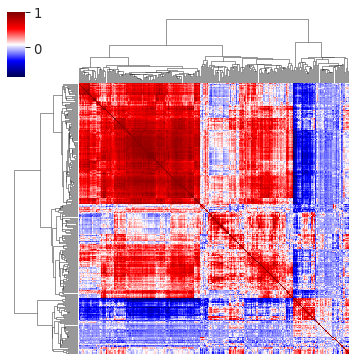

In [29]:
#this clustering better represented module overlap than default
row_clust = scipy.cluster.hierarchy.linkage(RLcorr, method='centroid', metric='euclidean', optimal_ordering=False)

clustmap = sns.clustermap(RLcorr,figsize=(5,5),cmap='seismic',
               yticklabels="",xticklabels="",col_linkage=row_clust,row_linkage=row_clust)

In [30]:
len(cliques_iterative_filtered)

5

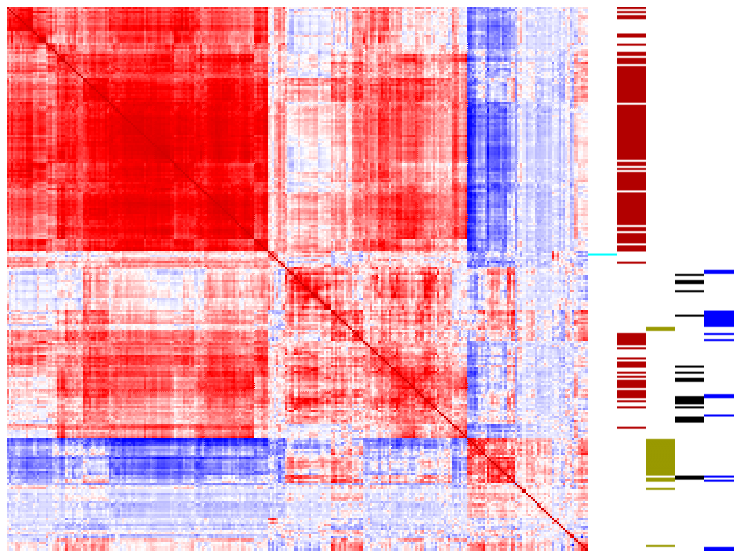

In [31]:
fig,ax=plt.subplots(1,len(cliques_iterative_filtered)+1,figsize=(13,10),
                    gridspec_kw={'width_ratios':[20]+[1]*len(cliques_iterative_filtered)})

rgb_cols_all = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[0,0,0],                         
[0,0,1],
[1,0,1],
[0,.6,0],]) #one row longer than epi

#axis 0: heatmap
RLcorr_reordered = RLcorr[clustmap.dendrogram_row.reordered_ind,:][:,clustmap.dendrogram_row.reordered_ind]
gene_reordered = np.array(RL_list)[clustmap.dendrogram_row.reordered_ind]
sns.heatmap(RLcorr_reordered,cmap='seismic',cbar=False,
               yticklabels="",xticklabels="",vmax=1.5,vmin=-1.5,ax=ax[0])

#axis 1-7: module colors
for j,clique in enumerate(range(len(cliques_iterative_filtered))):
    col_rgb_colors = np.array([rgb_cols_all[j,:] if gene in cliques_iterative_filtered[clique] else np.array([1,1,1]) for gene in gene_reordered])

    #col_rgb_colors = np.asarray([rgb_cols[j,:]])
    ax[j+1].imshow(np.tile(col_rgb_colors[:, None, :], [1, 1000, 1]),aspect="auto")
    ax[j+1].set_axis_off()


plt.subplots_adjust(wspace=0, hspace=.05)

plt.savefig(working_dir+"final_figures/Figure4/ImmuneRLCoexpression_B.png",bbox_inches='tight')

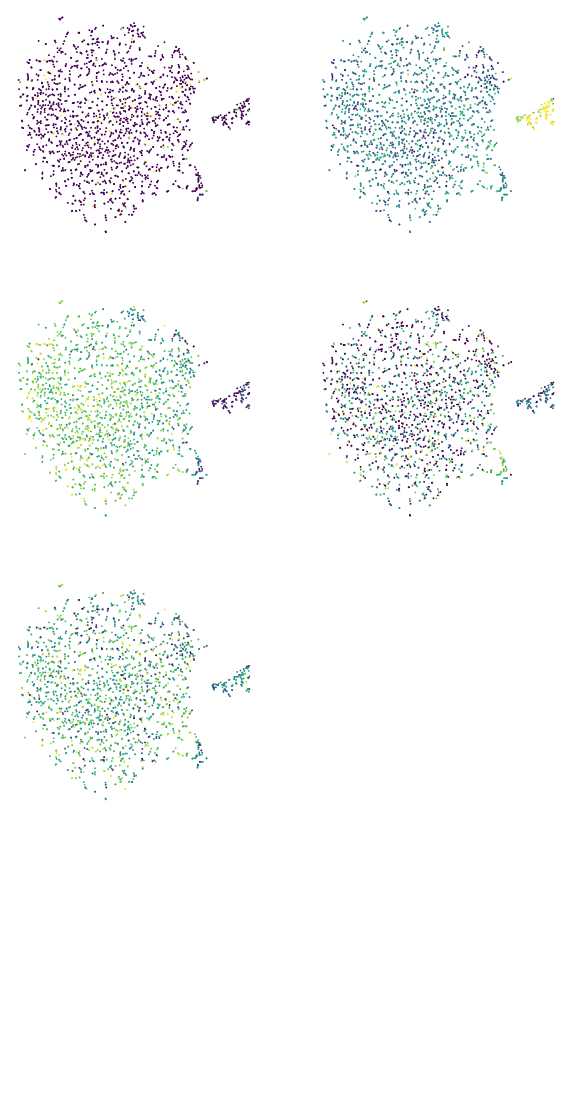

In [32]:
mat = []
fig,axes=plt.subplots(4,2,figsize=(10,20))
i=0
for i,genes in enumerate(cliques_iterative_filtered):
    colors = np.log2(sc.data_normalized[genes].values.mean(1)+.1)
    mat.append(colors)
    order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
    ax = axes.flatten()[i]
    ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],c=colors[order_],s=1,
              cmap='viridis',vmin=np.percentile(colors,2),vmax=np.percentile(colors,98))
    ax.set_axis_off()
    ax.set_title("")
    i+=1
while i < 8:
    axes.flatten()[i].set_axis_off()
    i+=1

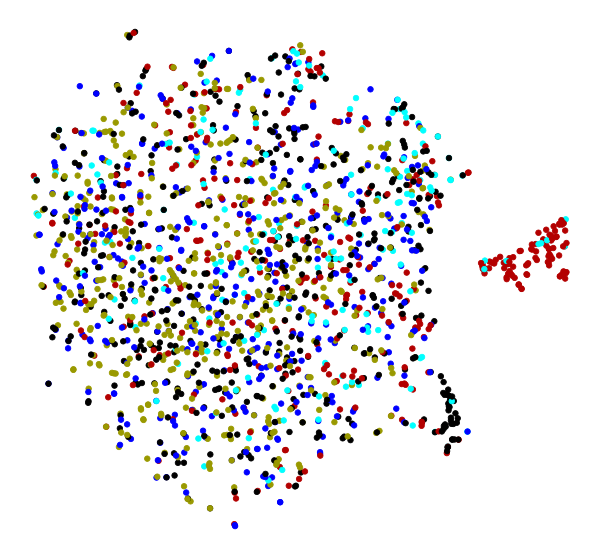

In [33]:
mat = np.vstack(mat)
mat_norm = ((mat.T - mat.mean(1))/mat.std(1)).T

hard_assignments = np.argmax(mat_norm,axis=0)

fig,ax=plt.subplots(1,1,figsize=(10.5,10))
order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
           c=rgb_cols_all[hard_assignments,:][order_,:],s=30)
ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure4/ImmuneCohort_BModules_Jan-24-22.png",bbox_inches='tight')

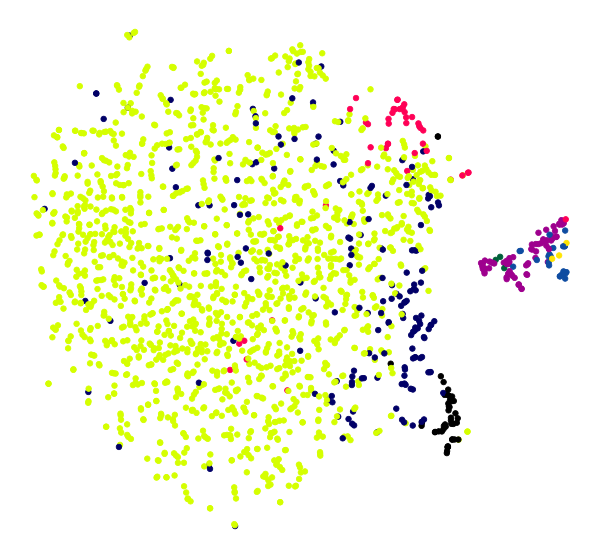

In [34]:
fig,ax=plt.subplots(1,1,figsize=(10.5,10))
encoder = LabelEncoder()
communities = encoder.fit_transform(sc.communities_refined)
cluster_colors = np.array([sc.palette[i] for i in communities])
order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
           c=cluster_colors[order_],s=30)
ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure4/ImmuneCohort_BClusters_Jan-24-22.png",bbox_inches='tight')

In [35]:
clusters_all = np.array(list(set(sc.communities_refined)))
cluster_sizes = [np.sum(sc.communities_refined==clust) for clust in clusters_all]
cluster_sizes

[66, 45, 3, 179, 23, 45, 3, 1621]

In [36]:
clusters_test = clusters_all[np.where(np.array(cluster_sizes)>10)[0]]

In [37]:
mod_cluster_mat = np.zeros((mat_norm.shape[0],len(clusters_test)))
for module in range(mat_norm.shape[0]):
    mod_ix = np.where(hard_assignments==module)[0]
    
    for i,cluster in enumerate(clusters_test):
        cluster_ix = np.where(sc.communities_refined==cluster)[0]
        mod_cluster_mat[module,i] = len(np.intersect1d(cluster_ix,mod_ix))

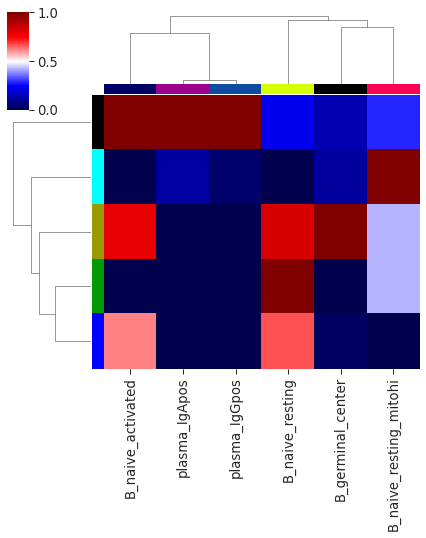

In [38]:
#row_order = [0,1,2,4,5,6,3]
#col_order = [2,3,5,4,0,1]

col_colors = [sc.palette[i] for i in encoder.transform(clusters_test)]

initial = sns.clustermap(mod_cluster_mat,standard_scale=1,cmap='seismic',
              figsize=(6,7.5),#row_cluster=False,col_cluster=False,
               xticklabels=clusters_test,yticklabels="",
               col_colors = col_colors,
               row_colors = rgb_cols_all)

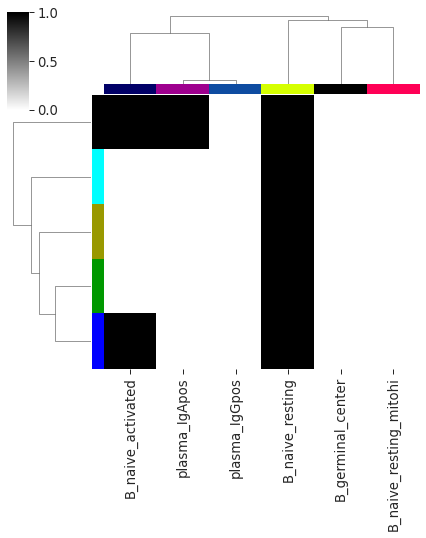

In [39]:
sns.clustermap((mod_cluster_mat.T/mod_cluster_mat.sum(1)).T>.1,cmap='binary',
               row_linkage=initial.dendrogram_row.linkage,
               col_linkage=initial.dendrogram_col.linkage,
               figsize=(6,7.5),#row_cluster=False,col_cluster=False,
               xticklabels=clusters_test,yticklabels="",
               col_colors = col_colors,
               row_colors = rgb_cols_all)

In [40]:
adjusted_rand_score(hard_assignments,sc.communities_refined)

0.030841137623131454

## Myeloid

This subset has updated annotations. We will add these first and then continue.

In [41]:
sc = load_sc(working_dir+"saved_analyses/CD45Plus_CrosstalkSubsetBase_myeloid_v1.pickle")
#use exact modules from paper
cliques_iterative_filtered = pickle.load(open(working_dir+"analysis_outputs/crosstalk/cliques_iterative_filtered_myeloid.pickle",'rb'))

In [42]:
adata_new = scanpy.read_h5ad(working_dir+"data/CustomFiltered/ImmuneData/2021_PDAC_dev_Peer_Lowe_merge_cohort_1and2_scran_clustered_imputed_annotated_7500_hv_clustered_imputed_annotated_from_subsets-v2.h5ad")
adata_orig = scanpy.read_h5ad(working_dir+"data/CustomFiltered/ImmuneData/2021_PDAC_dev_Peer_Lowe_merge_cohort_1and2_scran_clustered_imputed_annotated_7500_hv_clustered_imputed_annotated_from_subsets.h5ad")

In [43]:
orig_ix = list(np.array(adata_orig.obs.index))
cells_reorder = np.array([orig_ix.index(cell) for cell in np.array(adata_new.obs.index)])

In [44]:
adata_orig_reorder = adata_orig[cells_reorder]

In [45]:
celltypes1 = adata_new.obs['annotations_level_1'].values
for celltype in set(celltypes1):
    ix = np.where(celltypes1==celltype)[0]
    print("New Label:", celltype)
    print("Old Labels:")
    print(adata_orig_reorder.obs['annotations_level_1'].iloc[ix].value_counts())
    print(" ")

New Label: fibroblast
Old Labels:
mast      50
TAM        1
plasma     0
nan        0
gdT        0
T          0
ILC        0
Gr-MDC     0
DC         0
CD8_T      0
CD4_T      0
B          0
Name: annotations_level_1, dtype: int64
 
New Label: plasma
Old Labels:
plasma    359
nan         0
mast        0
gdT         0
TAM         0
T           0
ILC         0
Gr-MDC      0
DC          0
CD8_T       0
CD4_T       0
B           0
Name: annotations_level_1, dtype: int64
 
New Label: CD4_T
Old Labels:
CD4_T     5529
plasma       0
nan          0
mast         0
gdT          0
TAM          0
T            0
ILC          0
Gr-MDC       0
DC           0
CD8_T        0
B            0
Name: annotations_level_1, dtype: int64
 
New Label: gdT
Old Labels:
gdT       697
plasma      0
nan         0
mast        0
TAM         0
T           0
ILC         0
Gr-MDC      0
DC          0
CD8_T       0
CD4_T       0
B           0
Name: annotations_level_1, dtype: int64
 
New Label: CD8_T
Old Labels:
CD8_T     9

In [46]:
sc_cells = np.array(["{}-{}".format(sc.cell_ids[i],sc.sample_ids[i]) for i in range(len(sc.cell_ids))])

In [47]:
len(set(sc_cells)-set(adata_new.obs.index))

0

In [48]:
len(set(sc_cells)-set(adata_orig.obs.index))

0

In [49]:
for i in list(set(sc_cells)-set(adata_new.obs.index)):
    print(sc.communities_refined[list(sc_cells).index(i)])

In [50]:
new_annotations_coarse = []
for cell in sc_cells:
    try:
        new_annotations_coarse.append(adata_new.obs.loc[cell]['annotations_level_1'])
    except:
        new_annotations_coarse.append("missing")

new_annotations_refined = []
for cell in sc_cells:
    try:
        new_annotations_refined.append(adata_new.obs.loc[cell]['annotations_level_2'])
    except:
        new_annotations_refined.append("missing")

In [51]:
sc.communities_coarse = np.copy(new_annotations_coarse)
sc.communities_refined = np.copy(new_annotations_refined)

In [52]:
#remove 0 sum genes
sc.data_normalized = pd.DataFrame(sc.data_normalized_scran[:,np.where(sc.data_normalized_scran.sum(0)!=0)[0]],
                                  columns = np.array(list(sc.data_normalized_all))[np.where(sc.data_normalized_scran.sum(0)!=0)[0]],
                                  index = sc.data_normalized_all.index)
sc.genes = sc.data_normalized.columns

#impute with MAGIC
magic_operator = magic.MAGIC(t=3,n_pca=50)
sc.data_imputed = magic_operator.fit_transform(np.log2(sc.data_normalized+.1))

Calculating MAGIC...
  Running MAGIC on 5419 cells and 13380 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.99 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.33 seconds.
    Calculating affinities...
    Calculated affinities in 1.32 seconds.
  Calculated graph and diffusion operator in 5.96 seconds.
  Running MAGIC with `solver='exact'` on 13380-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 7.61 seconds.
Calculated MAGIC in 15.12 seconds.


In [53]:
RL_list = list(set(np.concatenate((receptor_fixed,ligand_fixed))))
RL_list = np.intersect1d(RL_list,list(sc.data_normalized))
RLdata_imputed = sc.data_imputed[RL_list]
RLdata_normalized = np.log2(sc.data_normalized[RL_list]+.1)

### Checking Saved Modules Align with Data

In [54]:
RLcorr = np.corrcoef(RLdata_imputed.T)
RLcorr_norm = np.corrcoef(RLdata_normalized.T)

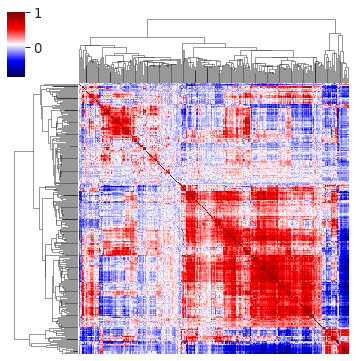

In [55]:
#this clustering better represented module overlap than default
row_clust = scipy.cluster.hierarchy.linkage(RLcorr, method='centroid', metric='euclidean', optimal_ordering=False)

clustmap = sns.clustermap(RLcorr,figsize=(5,5),cmap='seismic',
               yticklabels="",xticklabels="",col_linkage=row_clust,row_linkage=row_clust)

In [56]:
len(cliques_iterative_filtered)

7

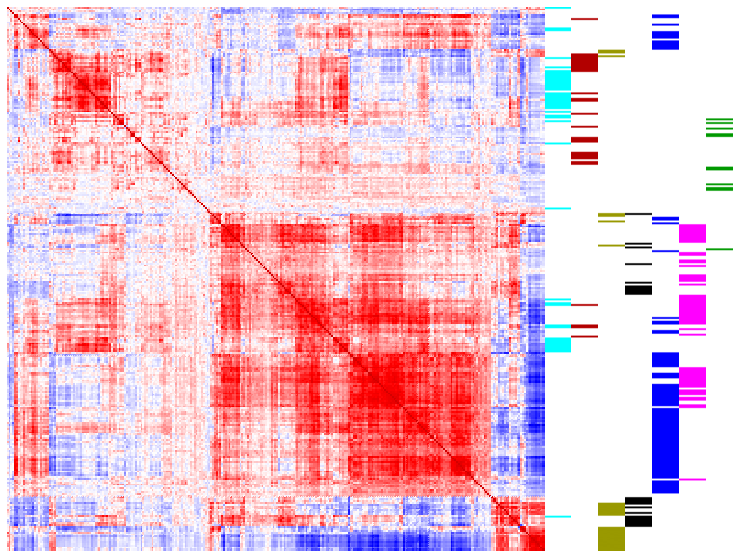

In [57]:
fig,ax=plt.subplots(1,len(cliques_iterative_filtered)+1,figsize=(13,10),
                    gridspec_kw={'width_ratios':[20]+[1]*len(cliques_iterative_filtered)})

rgb_cols_all = np.array([[0,1,1],
[.7,0,0],
[.6,.6,0],
[0,0,0],                         
[0,0,1],
[1,0,1],
[0,.6,0],]) #one row longer than epi

#axis 0: heatmap
RLcorr_reordered = RLcorr[clustmap.dendrogram_row.reordered_ind,:][:,clustmap.dendrogram_row.reordered_ind]
gene_reordered = np.array(RL_list)[clustmap.dendrogram_row.reordered_ind]
sns.heatmap(RLcorr_reordered,cmap='seismic',cbar=False,
               yticklabels="",xticklabels="",vmax=1.5,vmin=-1.5,ax=ax[0])

#axis 1-7: module colors
for j,clique in enumerate(range(len(cliques_iterative_filtered))):
    col_rgb_colors = np.array([rgb_cols_all[j,:] if gene in cliques_iterative_filtered[clique] else np.array([1,1,1]) for gene in gene_reordered])

    #col_rgb_colors = np.asarray([rgb_cols[j,:]])
    ax[j+1].imshow(np.tile(col_rgb_colors[:, None, :], [1, 1000, 1]),aspect="auto")
    ax[j+1].set_axis_off()


plt.subplots_adjust(wspace=0, hspace=.05)
plt.savefig(working_dir+"final_figures/Figure4/ImmuneRLCoexpression_myeloid.png",bbox_inches='tight')

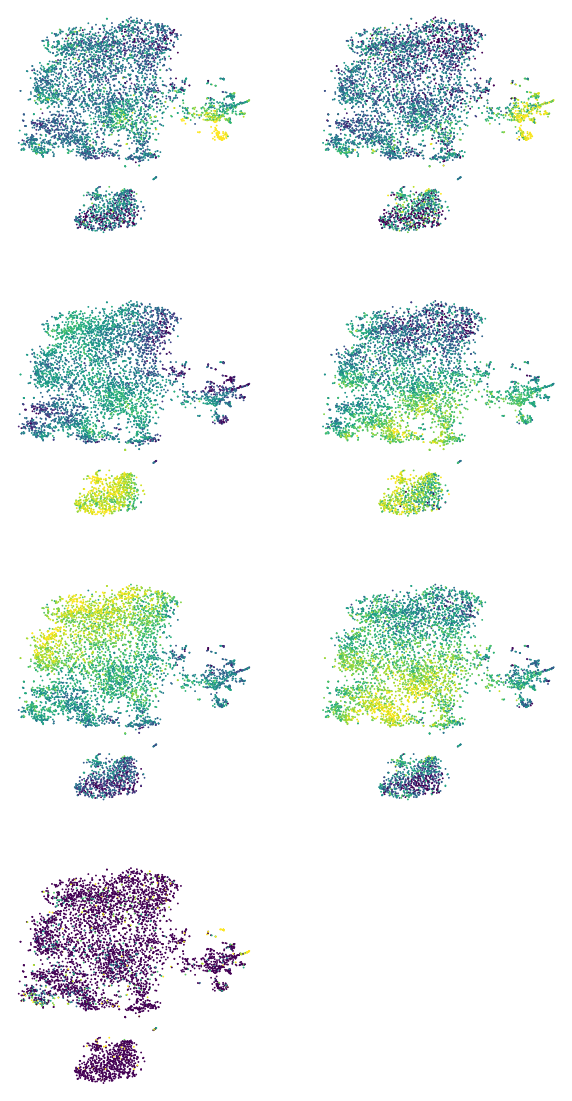

In [58]:
mat = []
fig,axes=plt.subplots(4,2,figsize=(10,20))
i=0
for i,genes in enumerate(cliques_iterative_filtered):
    colors = np.log2(sc.data_normalized[genes].values.mean(1)+.1)
    mat.append(colors)
    order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
    ax = axes.flatten()[i]
    ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],c=colors[order_],s=1,
              cmap='viridis',vmin=np.percentile(colors,2),vmax=np.percentile(colors,98))
    ax.set_axis_off()
    ax.set_title("")
    i+=1
while i < 8:
    axes.flatten()[i].set_axis_off()
    i+=1

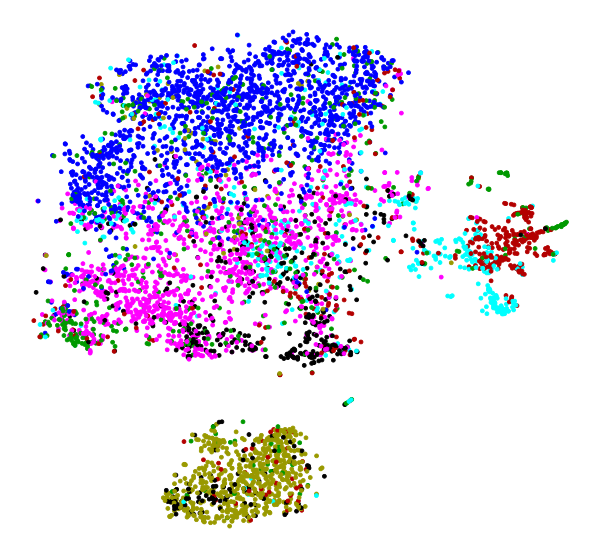

In [59]:
mat = np.vstack(mat)
mat_norm = ((mat.T - mat.mean(1))/mat.std(1)).T

hard_assignments = np.argmax(mat_norm,axis=0)

fig,ax=plt.subplots(1,1,figsize=(10.5,10))
order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
           c=rgb_cols_all[hard_assignments,:][order_,:],s=15)
ax.set_axis_off()
plt.savefig(working_dir+"final_figures/Figure4/ImmuneCohort_MyeloidModules_Jan-24-22.png",bbox_inches='tight')

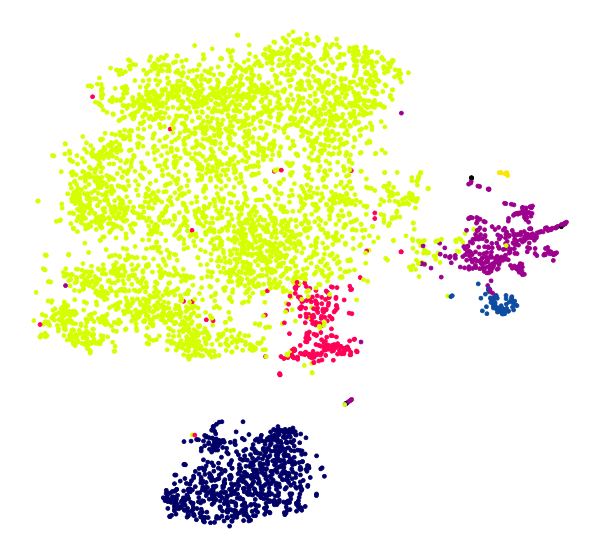

In [60]:
fig,ax=plt.subplots(1,1,figsize=(10.5,10))
encoder = LabelEncoder()
communities = encoder.fit_transform(sc.communities_refined)
cluster_colors = np.array([sc.palette[i] for i in communities])
order_ = np.random.choice(sc.data.shape[0],size=sc.data.shape[0],replace=False)
ax.scatter(sc.tsne_log[:,0][order_],sc.tsne_log[:,1][order_],
           c=cluster_colors[order_],s=15)
ax.set_axis_off()

plt.savefig(working_dir+"final_figures/Figure4/ImmuneCohort_MyeloidClusters_Jan-24-22.png",bbox_inches='tight')

In [61]:
set(sc.communities_refined)

{'DC_pDC', 'Gr-MDC', 'TAM', 'TAM_IFITMpos_IRF7pos', 'cDC', 'cDC3', 'mast'}

In [62]:
clusters_all = np.array(list(set(sc.communities_refined)))
cluster_sizes = [np.sum(sc.communities_refined==clust) for clust in clusters_all]
cluster_sizes

[7, 86, 772, 367, 3935, 237, 15]

In [63]:
clusters_test = clusters_all[np.where(np.array(cluster_sizes)>10)[0]]

In [64]:
mod_cluster_mat = np.zeros((mat_norm.shape[0],len(clusters_test)))
for module in range(mat_norm.shape[0]):
    mod_ix = np.where(hard_assignments==module)[0]
    
    for i,cluster in enumerate(clusters_test):
        cluster_ix = np.where(sc.communities_refined==cluster)[0]
        mod_cluster_mat[module,i] = len(np.intersect1d(cluster_ix,mod_ix))

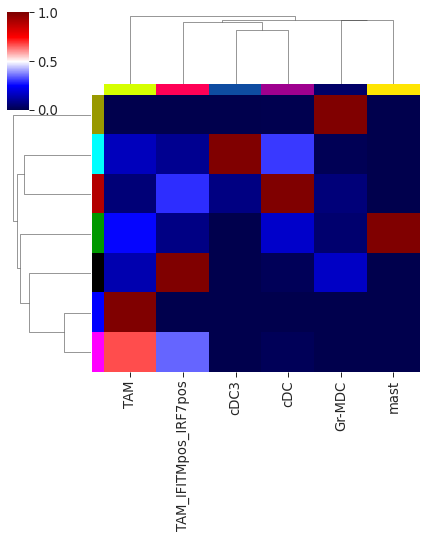

In [65]:
#row_order = [0,1,2,4,5,6,3]
#col_order = [2,3,5,4,0,1]

col_colors = [sc.palette[i] for i in encoder.transform(clusters_test)]

initial = sns.clustermap(mod_cluster_mat,standard_scale=1,cmap='seismic',
              figsize=(6,7.5),#row_cluster=False,col_cluster=False,
               xticklabels=clusters_test,yticklabels="",
               col_colors = col_colors,
               row_colors = rgb_cols_all)

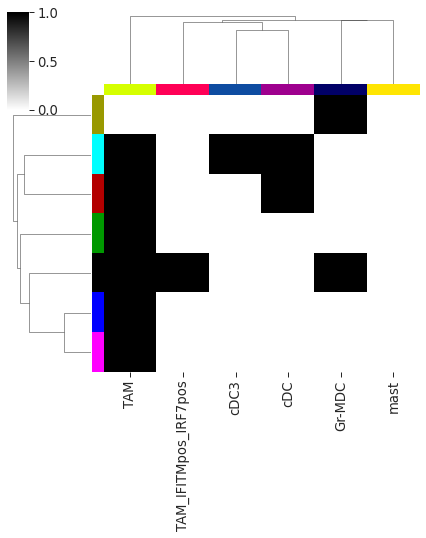

In [66]:
sns.clustermap((mod_cluster_mat.T/mod_cluster_mat.sum(1)).T>.1,cmap='binary',
               row_linkage=initial.dendrogram_row.linkage,
               col_linkage=initial.dendrogram_col.linkage,
               figsize=(6,7.5),#row_cluster=False,col_cluster=False,
               xticklabels=clusters_test,yticklabels="",
               col_colors = col_colors,
               row_colors = rgb_cols_all)

In [67]:
adjusted_rand_score(hard_assignments,sc.communities_refined)

0.20849587185116572

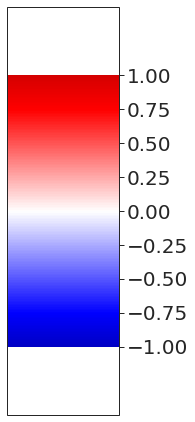

In [68]:
import matplotlib as mpl
fig,ax = plt.subplots(figsize=(2,5))

#adding colorbar
cmap = plt.get_cmap('seismic')
norm = mpl.colors.Normalize(vmin=-1.5, vmax=1.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm,ax)
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(20)
cbar.ax.set_ylim(-1,1)
plt.savefig(working_dir+"final_figures/Figure4/HeatmapScalebar_ImmuneRLCoexpression.pdf",bbox_inches='tight')